<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/03-Deep-Learning/notebooks/Tarea-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 1 - Tarea 1

Construir un clasificador MLP para predecir la clase de un documento de texto del corpus *20newsgroups* ([más información](http://qwone.com/~jason/20Newsgroups/)), el cual ya ha sido usado varias veces en clase.

Para esto, puedes usar tantas capas como desees, además, puedes modificar el número de neuronas, hacer dropout, usar callbacks y gridsearch (puede ser muy tardado). También podrías aplicar reducción de dimensionalidad a alguna de las matrices de features obtenidas. La función de perdida para la clasificación multiclase que usaremos es `categorical_crossentropy` y la métrica de rendimiento será el accuracy.

Una vez que tengas tu mejor modelo posible respecto al accuracy, reportar también las métricas:

* Recall
* Precision
* Roc-Auc score
* La matriz de confusión

Divide el conjunto de datos en 85% de entrenamiento y 15% de prueba.

**Fecha de entrega: Domingo 25 de junio**

En el siguiente link puedes encontrar las mejores accuracy que se han logrado, así como la estrategia. https://paperswithcode.com/sota/text-classification-on-20news

No es realista esperar obtener resultados de ese orden puesto que se trata de un problema no trivial. En sesiones posteriores iremos mejorando este resultado con algunas redes más especializadas.

## 1. Obtener el dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

full_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),
                               subset='all'
                              )


docs = full_data.data   # Los documentos
y = full_data.target    # Las clases de los documentos

In [2]:
type(docs)

list

In [3]:
docs[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [4]:
y[0]

10

In [5]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

Recuerda que para hacer clasificación multiclase con redes MLP necesitas tener las clases codificadas como *one-hot encoding*.

## 2. Obtención de features

Para obtener las features de cada documento usaremos dos estrategias:

1. El módelo bolsa de palabras (*Bag of words: BOW*). Para esto usaremos la clase `CountVectorizer` de scikit-learn.
2. El módelo TF-IDF. Para esto usaremos la clase `TfidfVectorizer` de scikit-learn. Los detalles de este modelo los puedes ver en la notebook de [clustering](https://github.com/DCDPUAEM/DCDP/blob/main/02-Machine-Learning/notebooks/12-Clustering.ipynb) del módulo pasado.

Además, limpiaremos el texto y lematizaremos.

> La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos. Por ejemplo, decir es el lema de dije, pero también de diré o dijéramos; guapo es el lema de guapas; mesa es el lema de mesas.



Bajamos las *stopwords*, signos de puntuación y el módulo *wordnet* (usado para sinónimos y lematización).

In [6]:
import nltk
from nltk import download

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Limpiamos el texto quitando signos de puntuación, números, símbolos especiales y pasando todo a minúsculas. Usamos la función que ya habíamos definido en el módulo pasado.

In [7]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py"
!wget --no-cache --backups=1 {url}

--2023-06-26 02:31:01--  https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/limpiador_texto.py
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8001::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 651 [text/plain]
Grabando a: “limpiador_texto.py”

limpiador_texto.py  100%[===================>]     651  --.-KB/s    in 0s      

2023-06-26 02:31:06 (13.0 MB/s) - “limpiador_texto.py” guardado [651/651]



In [8]:
from limpiador_texto import preprocesar_textos

clean_docs = preprocesar_textos(docs)

Veamos como va el corpus hasta el momento

In [9]:
docs[10]

'the blood of the lamb.\n\nThis will be a hard task, because most cultures used most animals\nfor blood sacrifices. It has to be something related to our current\npost-modernism state. Hmm, what about used computers?\n\nCheers,\nKent'

In [10]:
clean_docs[10]

'blood lamb hard task cultures used animals blood sacrifices something related current postmodernism state hmm used computers cheers kent'

In [11]:
import pandas as pd

docs_df = pd.DataFrame(data={'document': clean_docs,
                             'class': y})
docs_df

,document,class
0,sure bashers pens fans pretty confused lack ki...,10
1,brother market highperformance video card supp...,3
2,finally said dream mediterranean new area grea...,17
3,think scsi card dma transfers disks scsi card ...,3
4,old jasmine drive use new system understanding...,4
...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13
18842,isolated ground recepticles usually unusual co...,12
18843,installed dx cpu clone motherboard tried mount...,3
18844,wouldnt require hypersphere space points speci...,1


Lematizamos

In [12]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(" ".join([lemmatizer.lemmatize(w,"v") for w in w_tokenizer.tokenize(text)]))

docs_df["lemmatized_document"] = docs_df['document'].apply(lemmatize_text)
docs_df

,document,class,lemmatized_document
0,sure bashers pens fans pretty confused lack ki...,10,sure bashers pen fan pretty confuse lack kind ...
1,brother market highperformance video card supp...,3,brother market highperformance video card supp...
2,finally said dream mediterranean new area grea...,17,finally say dream mediterranean new area great...
3,think scsi card dma transfers disks scsi card ...,3,think scsi card dma transfer disk scsi card dm...
4,old jasmine drive use new system understanding...,4,old jasmine drive use new system understand up...
...,...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurology d...,13,dn nyedacnsvaxuwecedu david nye dn neurology d...
18842,isolated ground recepticles usually unusual co...,12,isolate grind recepticles usually unusual colo...
18843,installed dx cpu clone motherboard tried mount...,3,instal dx cpu clone motherboard try mount cpu ...
18844,wouldnt require hypersphere space points speci...,1,wouldnt require hypersphere space point specif...


Creamos una lista con los documentos preprocesados

In [13]:
clean_docs_prelemmantized = clean_docs.copy()
clean_docs=list(docs_df["lemmatized_document"].values)

In [14]:
print(clean_docs_prelemmantized[10])
print()
print(clean_docs[10])

blood lamb hard task cultures used animals blood sacrifices something related current postmodernism state hmm used computers cheers kent

blood lamb hard task culture use animals blood sacrifice something relate current postmodernism state hmm use computers cheer kent


## 3. El modelo

### 3.1  TF-IDF

Obtenemos la matriz de features TF-IDF. Recuerda que `topn_words` especifica cuántas palabras del vocabulario tomar, ordenadas por las más frecuentes.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

topn_words = 800

vectorizer = TfidfVectorizer(stop_words='english',
                             max_features=topn_words)
X_tfidf = vectorizer.fit_transform(clean_docs)
X_tfidf = np.asarray(X_tfidf.todense())
print(X_tfidf.shape)

(18846, 800)


In [16]:
# codificamos las etiquetas en one-hot
from tensorflow.keras.utils import to_categorical

print("---------- Antes de la codificación ----------")
print(f"Primeras 5 etiquetas: {y[:5]}")
print(f"Shape: {y.shape}")

y_oh = to_categorical(y,num_classes=20)

print("---------- Después de la codificación ----------")
print(f"Primeras 5 etiquetas:\n{y_oh[:5]}")
print(f"Shape: {y_oh.shape}")


2023-06-26 02:31:28.152289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------- Antes de la codificación ----------
Primeras 5 etiquetas: [10  3 17  3  4]
Shape: (18846,)
---------- Después de la codificación ----------
Primeras 5 etiquetas:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Shape: (18846, 20)


In [17]:
# split de train y test sets
from tensorflow.python import train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y_oh,train_size=0.85)#,random_state=189)

In [18]:
# funciones auxiliares

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #history.epoch
    #epochs = range(len(history.history['loss'])+1)
    plt.plot(history.epoch, history.history['loss'],
            label='Loss')
    plt.plot(history.epoch, history.history['val_loss'],
            label = 'Loss Validation')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, history.history['categorical_accuracy'],
            label='Categorical Accuracy')
    plt.plot(history.epoch, history.history['val_categorical_accuracy'],
            label = 'Categorical Accuracy Validation')
    plt.legend()
    plt.show()


In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16019, 800)
(16019, 20)
(2827, 800)
(2827, 20)


In [20]:
# Tu modelo ...

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import Dense, Flatten
from keras.models import Sequential


def build_model(X,y):
    
    accuracy = keras.metrics.CategoricalAccuracy()
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    #optimizer = keras.optimizers.Adam(learning_rate=0.001)
    optimizer = keras.optimizers.SGD()
    
    model = keras.Sequential([
    
    layers.Dense(200, activation='tanh', input_dim=X.shape[1]),
    Dropout(0.663),
        
    layers.Dense(200, activation='tanh'),
    Dropout(0.663),        
        
    layers.Dense(200, activation='tanh'),
    Dropout(0.663),        
        
    layers.Dense(200, activation='tanh'),
    Dropout(0.663),        

    layers.Dense(200, activation='tanh'),
    Dropout(0.663),

    layers.Dense(y.shape[1], activation=None)
    
    ])
    
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = keras.optimizers.experimental.SGD(learning_rate=0.01)
    #accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    model.compile(loss=loss_fn,
                optimizer=optimizer,
                 #metrics=['accuracy']
                  metrics=accuracy
                 )
    return model


def build_model_for_gridsearch(X,y,n_neurons=200,activations='tanh',hid_layers=5,dropout=True):
    
    accuracy = keras.metrics.CategoricalAccuracy()
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    #optimizer = keras.optimizers.Adam(learning_rate=0.001)
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = keras.optimizers.experimental.SGD(learning_rate=0.01)
    #accuracy = tf.keras.metrics.CategoricalAccuracy()
    optimizer = keras.optimizers.SGD()
    
    model = Sequential()
    
    model.add(layers.Dense(200, activation=activations, input_dim=X.shape[1]))
    if dropout:
        model.add(Dropout(0.663))
    
    for i in range(hid_layers):
        model.add(Dense(n_neurons, activation=activations))
        if dropout:
            model.add(Dropout(0.663))
        
    model.add( layers.Dense(y.shape[1], activation=None) )
    
    model.compile(loss=loss_fn,
                optimizer=optimizer,
                 #metrics=['accuracy']
                  metrics=[accuracy]
                 )
    return model

In [21]:
#----- Construimos un solo modelo -------
model1 = build_model(X_train,y_train)

model1.summary()

#----- Entremamos el modelo ------
epochs = 300
model1_history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1, validation_split = 0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               160200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               4

2023-06-26 02:31:29.901825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


501/501 [==============================] - 2s 3ms/step - loss: 3.2249 - categorical_accuracy: 0.0531 - val_loss: 2.9711 - val_categorical_accuracy: 0.1104
Epoch 2/300
501/501 [==============================] - 1s 3ms/step - loss: 3.1613 - categorical_accuracy: 0.0540 - val_loss: 2.9563 - val_categorical_accuracy: 0.1613
Epoch 3/300
501/501 [==============================] - 1s 3ms/step - loss: 3.1167 - categorical_accuracy: 0.0579 - val_loss: 2.9422 - val_categorical_accuracy: 0.2274
Epoch 4/300
501/501 [==============================] - 1s 3ms/step - loss: 3.0810 - categorical_accuracy: 0.0607 - val_loss: 2.9247 - val_categorical_accuracy: 0.2543
Epoch 5/300
501/501 [==============================] - 1s 3ms/step - loss: 3.0488 - categorical_accuracy: 0.0629 - val_loss: 2.8966 - val_categorical_accuracy: 0.2741
Epoch 6/300
501/501 [==============================] - 1s 3ms/step - loss: 3.0122 - categorical_accuracy: 0.0755 - val_loss: 2.8441 - val_categorical_accuracy: 0.2674
Epoch 7/30

Epoch 50/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8919 - categorical_accuracy: 0.3761 - val_loss: 1.7087 - val_categorical_accuracy: 0.4422
Epoch 51/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8943 - categorical_accuracy: 0.3777 - val_loss: 1.7025 - val_categorical_accuracy: 0.4393
Epoch 52/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8911 - categorical_accuracy: 0.3820 - val_loss: 1.7033 - val_categorical_accuracy: 0.4478
Epoch 53/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8814 - categorical_accuracy: 0.3837 - val_loss: 1.6989 - val_categorical_accuracy: 0.4542
Epoch 54/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8830 - categorical_accuracy: 0.3761 - val_loss: 1.6926 - val_categorical_accuracy: 0.4482
Epoch 55/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8719 - categorical_accuracy: 0.3772 - val_loss: 1.6964 - val_categorical_accuracy:

Epoch 99/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7886 - categorical_accuracy: 0.4214 - val_loss: 1.6761 - val_categorical_accuracy: 0.4701
Epoch 100/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7734 - categorical_accuracy: 0.4189 - val_loss: 1.6764 - val_categorical_accuracy: 0.4683
Epoch 101/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7747 - categorical_accuracy: 0.4228 - val_loss: 1.6681 - val_categorical_accuracy: 0.4765
Epoch 102/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7746 - categorical_accuracy: 0.4186 - val_loss: 1.6711 - val_categorical_accuracy: 0.4719
Epoch 103/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7701 - categorical_accuracy: 0.4222 - val_loss: 1.6801 - val_categorical_accuracy: 0.4528
Epoch 104/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7602 - categorical_accuracy: 0.4251 - val_loss: 1.6773 - val_categorical_accu

501/501 [==============================] - 1s 3ms/step - loss: 1.7185 - categorical_accuracy: 0.4454 - val_loss: 1.6597 - val_categorical_accuracy: 0.4786
Epoch 148/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7222 - categorical_accuracy: 0.4405 - val_loss: 1.6550 - val_categorical_accuracy: 0.4779
Epoch 149/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7282 - categorical_accuracy: 0.4437 - val_loss: 1.6630 - val_categorical_accuracy: 0.4790
Epoch 150/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7133 - categorical_accuracy: 0.4432 - val_loss: 1.6618 - val_categorical_accuracy: 0.4751
Epoch 151/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7251 - categorical_accuracy: 0.4465 - val_loss: 1.6549 - val_categorical_accuracy: 0.4807
Epoch 152/300
501/501 [==============================] - 1s 3ms/step - loss: 1.7188 - categorical_accuracy: 0.4409 - val_loss: 1.6606 - val_categorical_accuracy: 0.4836


501/501 [==============================] - 1s 3ms/step - loss: 1.6786 - categorical_accuracy: 0.4623 - val_loss: 1.6349 - val_categorical_accuracy: 0.4881
Epoch 196/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6854 - categorical_accuracy: 0.4607 - val_loss: 1.6304 - val_categorical_accuracy: 0.4931
Epoch 197/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6662 - categorical_accuracy: 0.4653 - val_loss: 1.6481 - val_categorical_accuracy: 0.4828
Epoch 198/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6735 - categorical_accuracy: 0.4606 - val_loss: 1.6329 - val_categorical_accuracy: 0.4959
Epoch 199/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6753 - categorical_accuracy: 0.4601 - val_loss: 1.6250 - val_categorical_accuracy: 0.4896
Epoch 200/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6720 - categorical_accuracy: 0.4618 - val_loss: 1.6398 - val_categorical_accuracy: 0.4924


501/501 [==============================] - 1s 3ms/step - loss: 1.6121 - categorical_accuracy: 0.4863 - val_loss: 1.6051 - val_categorical_accuracy: 0.5080
Epoch 244/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6197 - categorical_accuracy: 0.4816 - val_loss: 1.6086 - val_categorical_accuracy: 0.5069
Epoch 245/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6120 - categorical_accuracy: 0.4832 - val_loss: 1.6075 - val_categorical_accuracy: 0.5090
Epoch 246/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6165 - categorical_accuracy: 0.4852 - val_loss: 1.6024 - val_categorical_accuracy: 0.5083
Epoch 247/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6055 - categorical_accuracy: 0.4884 - val_loss: 1.6113 - val_categorical_accuracy: 0.5090
Epoch 248/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6087 - categorical_accuracy: 0.4889 - val_loss: 1.6065 - val_categorical_accuracy: 0.5108


501/501 [==============================] - 1s 3ms/step - loss: 1.5879 - categorical_accuracy: 0.4986 - val_loss: 1.5987 - val_categorical_accuracy: 0.5129
Epoch 292/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5853 - categorical_accuracy: 0.4982 - val_loss: 1.6019 - val_categorical_accuracy: 0.5136
Epoch 293/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5823 - categorical_accuracy: 0.5008 - val_loss: 1.6042 - val_categorical_accuracy: 0.5189
Epoch 294/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5763 - categorical_accuracy: 0.5008 - val_loss: 1.6031 - val_categorical_accuracy: 0.5168
Epoch 295/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5764 - categorical_accuracy: 0.5033 - val_loss: 1.6011 - val_categorical_accuracy: 0.5232
Epoch 296/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5793 - categorical_accuracy: 0.4983 - val_loss: 1.6087 - val_categorical_accuracy: 0.5196


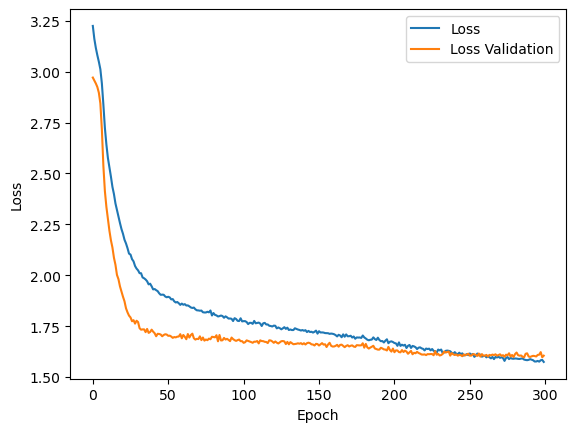

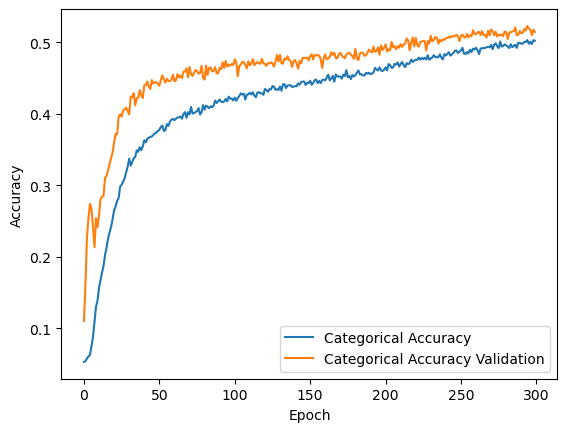

89/89 - 0s - loss: 1.6049 - categorical_accuracy: 0.5147 - 120ms/epoch - 1ms/step
Categorical accuracy para las predicciones en el conjunto de prueba: 0.5147


In [22]:
plot_history(model1_history)

loss, cat_accr = model1.evaluate(X_test, y_test, verbose=2)
print(f"Categorical accuracy para las predicciones en el conjunto de prueba: {np.round(cat_accr,4)}")

In [23]:
import seaborn as sns

clf = model1
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict(X_test)#[:, 1]

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pmAccuracy=round(accuracy_score(y_test_labels,y_pred_labels),3)
pmRecall=round(recall_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmPrecision=round(precision_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmF1=round(f1_score(y_test_labels, y_pred_labels, average='weighted'),3)

pmRocAuc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Resultados de desempeño:")

#print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

# Create the prediction matrix
prediction_matrix = np.zeros((20, 20), dtype=int)

for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    prediction_matrix[true_label, pred_label] += 1

class_labels = range(20) 
    
# Plot the prediction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(prediction_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction Matrix')
plt.show()

89/89 [==============================] - 0s 1ms/step
Resultados de desempeño:
Accuracy: 0.515
Recall: 0.515
Precision: 0.504
F1: 0.506
ROC-AUC: 0.8770612276730093


# GridSearch

In [24]:
# Preparamos gridsearch

from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

model = KerasClassifier(
    build_model_for_gridsearch,
    X=X_train,
    y=y_train,
    n_neurons=50,
    activations='sigmoid',
    epochs=300,
    verbose=1,
    callbacks=[es],
    validation_split=0.15,
    #scoring='accuracy'
)

In [25]:
from sklearn.model_selection import GridSearchCV

# ----- Definimos los parámetros de la busqueda -----
neurons = [10,100,200]
activations = ['relu','sigmoid','tanh']
param_grid = {'n_neurons':neurons,
              'activations':activations}

# ----- Definimos y realizamos el gridsearch
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = gs.fit(X_train, y_train)

print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

2023-06-26 02:38:50.445490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:38:50.574188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:38:50.663201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/300
Epoch 1/300


2023-06-26 02:38:53.547476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:38:53.570414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:38:53.598807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/300
Epoch 1/300
Epoch 1/300


2023-06-26 02:38:53.848834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
Epoch 1/300
Epoch 1/300
284/284 [==============================] - 4s 8ms/step - loss: 2.9977 - categorical_accuracy: 0.0523 - val_loss: 2.9949 - val_categorical_accuracy: 0.0537
Epoch 2/300
284/284 [==============================] - 4s 8ms/step - loss: 2.9970 - categorical_accuracy: 0.0519 - val_loss: 2.9943 - val_categorical_accuracy: 0.0499
Epoch 2/300
284/284 [==============================] - 4s 10ms/step - loss: 3.0028 - categorical_accuracy: 0.0501 - val_loss: 2.9946 - val_categorical_accuracy: 0.0499
Epoch 2/300
284/284 [==============================] - 4s 9ms/step - loss: 3.0051 - categorical_accuracy: 0.0495 - val_loss: 2.9940 - val_categorical_accuracy: 0.0499
Epoch 2/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9946 - categorical_accuracy: 0.0549 - val_loss: 2.9933 - val_categorical_accuracy: 0.0499
Epoch 3/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9953 - categorical_accuracy: 0.0564 - val_loss: 2.9942 - val_ca

284/284 [==============================] - 3s 12ms/step - loss: 2.9935 - categorical_accuracy: 0.0562 - val_loss: 2.9911 - val_categorical_accuracy: 0.0499
Epoch 5/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9917 - categorical_accuracy: 0.0551 - val_loss: 2.9927 - val_categorical_accuracy: 0.0499
Epoch 9/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9910 - categorical_accuracy: 0.0554 - val_loss: 2.9906 - val_categorical_accuracy: 0.0499
Epoch 9/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9921 - categorical_accuracy: 0.0549 - val_loss: 2.9927 - val_categorical_accuracy: 0.0499
Epoch 8/300
284/284 [==============================] - 3s 12ms/step - loss: 2.9929 - categorical_accuracy: 0.0559 - val_loss: 2.9931 - val_categorical_accuracy: 0.0375
Epoch 6/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9907 - categorical_accuracy: 0.0561 - val_loss: 2.9904 - val_categorical_accuracy: 0.0499
Epoch 10

284/284 [==============================] - 2s 6ms/step - loss: 2.9900 - categorical_accuracy: 0.0559 - val_loss: 2.9900 - val_categorical_accuracy: 0.0499
Epoch 16/300
284/284 [==============================] - 3s 12ms/step - loss: 2.9939 - categorical_accuracy: 0.0552 - val_loss: 2.9938 - val_categorical_accuracy: 0.0562
Epoch 4/300
284/284 [==============================] - 4s 8ms/step - loss: 3.1679 - categorical_accuracy: 0.0514 - val_loss: 3.0063 - val_categorical_accuracy: 0.0493
Epoch 2/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9911 - categorical_accuracy: 0.0526 - val_loss: 2.9925 - val_categorical_accuracy: 0.0499
Epoch 16/300
284/284 [==============================] - 2s 7ms/step - loss: 3.1103 - categorical_accuracy: 0.0496 - val_loss: 3.0011 - val_categorical_accuracy: 0.0537
Epoch 3/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9901 - categorical_accuracy: 0.0555 - val_loss: 2.9899 - val_categorical_accuracy: 0.0499
Epoch 1

284/284 [==============================] - 3s 10ms/step - loss: 2.9906 - categorical_accuracy: 0.0573 - val_loss: 2.9897 - val_categorical_accuracy: 0.0499
Epoch 13/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0270 - categorical_accuracy: 0.0566 - val_loss: 2.9902 - val_categorical_accuracy: 0.0499
Epoch 9/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0278 - categorical_accuracy: 0.0509 - val_loss: 2.9929 - val_categorical_accuracy: 0.0499
Epoch 10/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9899 - categorical_accuracy: 0.0560 - val_loss: 2.9898 - val_categorical_accuracy: 0.0499
Epoch 24/300
284/284 [==============================] - 2s 8ms/step - loss: 2.9900 - categorical_accuracy: 0.0567 - val_loss: 2.9901 - val_categorical_accuracy: 0.0499
Epoch 20/300
284/284 [==============================] - 3s 12ms/step - loss: 2.9923 - categorical_accuracy: 0.0520 - val_loss: 2.9935 - val_categorical_accuracy: 0.0562
Epoc

284/284 [==============================] - 2s 7ms/step - loss: 3.2084 - categorical_accuracy: 0.0549 - val_loss: 2.9892 - val_categorical_accuracy: 0.0562
Epoch 4/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0047 - categorical_accuracy: 0.0571 - val_loss: 2.9922 - val_categorical_accuracy: 0.0499
Epoch 18/300
284/284 [==============================] - 3s 10ms/step - loss: 2.9899 - categorical_accuracy: 0.0548 - val_loss: 2.9893 - val_categorical_accuracy: 0.0499
Epoch 18/300
284/284 [==============================] - 2s 8ms/step - loss: 3.1746 - categorical_accuracy: 0.0509 - val_loss: 2.9914 - val_categorical_accuracy: 0.0562
Epoch 5/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0321 - categorical_accuracy: 0.0536 - val_loss: 2.9942 - val_categorical_accuracy: 0.0499
Epoch 9/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0097 - categorical_accuracy: 0.0527 - val_loss: 2.9921 - val_categorical_accuracy: 0.0499
Epoch 1

284/284 [==============================] - 4s 8ms/step - loss: 3.1621 - categorical_accuracy: 0.0482 - val_loss: 2.9935 - val_categorical_accuracy: 0.0612
Epoch 2/300
284/284 [==============================] - 3s 11ms/step - loss: 3.2936 - categorical_accuracy: 0.0511 - val_loss: 2.9950 - val_categorical_accuracy: 0.0562
Epoch 3/300
284/284 [==============================] - 4s 9ms/step - loss: 3.4818 - categorical_accuracy: 0.0519 - val_loss: 2.9819 - val_categorical_accuracy: 0.0749
Epoch 2/300
284/284 [==============================] - 4s 9ms/step - loss: 3.4698 - categorical_accuracy: 0.0466 - val_loss: 2.9938 - val_categorical_accuracy: 0.0637
Epoch 2/300
284/284 [==============================] - 2s 6ms/step - loss: 3.1174 - categorical_accuracy: 0.0503 - val_loss: 2.9928 - val_categorical_accuracy: 0.0487
Epoch 3/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0569 - categorical_accuracy: 0.0491 - val_loss: 2.9886 - val_categorical_accuracy: 0.0562
Epoch 5/3

284/284 [==============================] - 2s 6ms/step - loss: 3.0074 - categorical_accuracy: 0.0570 - val_loss: 2.9880 - val_categorical_accuracy: 0.0543
Epoch 11/300
284/284 [==============================] - 2s 8ms/step - loss: 3.1345 - categorical_accuracy: 0.0476 - val_loss: 2.9776 - val_categorical_accuracy: 0.0562
Epoch 8/300
284/284 [==============================] - 2s 7ms/step - loss: 3.1469 - categorical_accuracy: 0.0499 - val_loss: 2.9831 - val_categorical_accuracy: 0.0955
Epoch 7/300
284/284 [==============================] - 1s 5ms/step - loss: 3.0071 - categorical_accuracy: 0.0572 - val_loss: 2.9880 - val_categorical_accuracy: 0.0512
Epoch 12/300
284/284 [==============================] - 3s 11ms/step - loss: 3.2315 - categorical_accuracy: 0.0531 - val_loss: 2.9727 - val_categorical_accuracy: 0.1305
Epoch 5/300
284/284 [==============================] - 2s 7ms/step - loss: 3.1156 - categorical_accuracy: 0.0505 - val_loss: 2.9825 - val_categorical_accuracy: 0.0949
Epoch 8

284/284 [==============================] - 2s 5ms/step - loss: 3.0173 - categorical_accuracy: 0.0570 - val_loss: 2.9702 - val_categorical_accuracy: 0.0855
Epoch 18/300
284/284 [==============================] - 2s 8ms/step - loss: 3.1189 - categorical_accuracy: 0.0530 - val_loss: 2.9676 - val_categorical_accuracy: 0.1579
Epoch 9/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0231 - categorical_accuracy: 0.0565 - val_loss: 2.9741 - val_categorical_accuracy: 0.1305
Epoch 17/300
284/284 [==============================] - 2s 8ms/step - loss: 3.0693 - categorical_accuracy: 0.0561 - val_loss: 2.9581 - val_categorical_accuracy: 0.1542
Epoch 12/300
284/284 [==============================] - 2s 5ms/step - loss: 3.0212 - categorical_accuracy: 0.0556 - val_loss: 2.9679 - val_categorical_accuracy: 0.0886
Epoch 19/300
284/284 [==============================] - 2s 8ms/step - loss: 3.0750 - categorical_accuracy: 0.0571 - val_loss: 2.9603 - val_categorical_accuracy: 0.1536
Epoch 

284/284 [==============================] - 2s 8ms/step - loss: 2.9687 - categorical_accuracy: 0.0735 - val_loss: 2.8027 - val_categorical_accuracy: 0.1436
Epoch 17/300
284/284 [==============================] - 2s 8ms/step - loss: 2.8849 - categorical_accuracy: 0.0924 - val_loss: 2.6717 - val_categorical_accuracy: 0.1317
Epoch 20/300
284/284 [==============================] - 2s 6ms/step - loss: 2.7968 - categorical_accuracy: 0.0982 - val_loss: 2.6151 - val_categorical_accuracy: 0.1086
Epoch 31/300
284/284 [==============================] - 2s 6ms/step - loss: 2.7815 - categorical_accuracy: 0.0962 - val_loss: 2.6036 - val_categorical_accuracy: 0.1067
Epoch 29/300
284/284 [==============================] - 2s 8ms/step - loss: 2.8251 - categorical_accuracy: 0.0940 - val_loss: 2.6064 - val_categorical_accuracy: 0.1529
Epoch 21/300
284/284 [==============================] - 2s 8ms/step - loss: 2.9092 - categorical_accuracy: 0.0835 - val_loss: 2.7014 - val_categorical_accuracy: 0.1361
Epoch

284/284 [==============================] - 2s 8ms/step - loss: 2.6353 - categorical_accuracy: 0.1242 - val_loss: 2.4344 - val_categorical_accuracy: 0.1792
Epoch 28/300
284/284 [==============================] - 2s 6ms/step - loss: 2.6486 - categorical_accuracy: 0.1070 - val_loss: 2.5633 - val_categorical_accuracy: 0.1167
Epoch 39/300
284/284 [==============================] - 2s 8ms/step - loss: 2.6701 - categorical_accuracy: 0.1074 - val_loss: 2.5322 - val_categorical_accuracy: 0.1773
Epoch 25/300
284/284 [==============================] - 2s 5ms/step - loss: 2.6153 - categorical_accuracy: 0.1215 - val_loss: 2.4396 - val_categorical_accuracy: 0.1573
Epoch 42/300
284/284 [==============================] - 2s 8ms/step - loss: 2.6419 - categorical_accuracy: 0.1258 - val_loss: 2.4449 - val_categorical_accuracy: 0.1698
Epoch 28/300
284/284 [==============================] - 2s 6ms/step - loss: 2.6368 - categorical_accuracy: 0.1058 - val_loss: 2.5612 - val_categorical_accuracy: 0.1136
Epoch

284/284 [==============================] - 2s 5ms/step - loss: 2.4416 - categorical_accuracy: 0.1744 - val_loss: 2.2682 - val_categorical_accuracy: 0.2160
Epoch 38/300
284/284 [==============================] - 2s 5ms/step - loss: 2.4156 - categorical_accuracy: 0.1785 - val_loss: 2.2192 - val_categorical_accuracy: 0.2472
Epoch 39/300
284/284 [==============================] - 1s 5ms/step - loss: 2.4261 - categorical_accuracy: 0.1752 - val_loss: 2.2242 - val_categorical_accuracy: 0.2297
Epoch 39/300
284/284 [==============================] - 1s 4ms/step - loss: 2.4106 - categorical_accuracy: 0.1791 - val_loss: 2.1889 - val_categorical_accuracy: 0.2459
Epoch 40/300
284/284 [==============================] - 1s 4ms/step - loss: 2.3958 - categorical_accuracy: 0.1834 - val_loss: 2.1853 - val_categorical_accuracy: 0.2434
Epoch 41/300
284/284 [==============================] - 1s 4ms/step - loss: 2.4081 - categorical_accuracy: 0.1854 - val_loss: 2.2043 - val_categorical_accuracy: 0.2310
Epoch

In [26]:
#y_true
#y_pred_proba
#y_pred_proba = clf.predict_proba(X_test)
#y_pred_proba[:, 1][:5]
#y_test

In [27]:
#print(y_true[:5])
#print(y_pred_argmax[:5])

In [28]:
#clf.history_

In [ ]:
import seaborn as sns
print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

clf = grid_result.best_estimator_

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict(X_test)#[:, 1]

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pmAccuracy=round(accuracy_score(y_test_labels,y_pred_labels),3)
pmRecall=round(recall_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmPrecision=round(precision_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmF1=round(f1_score(y_test_labels, y_pred_labels, average='weighted'),3)

pmRocAuc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Resultados de desempeño:")

#print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

# Create the prediction matrix
prediction_matrix = np.zeros((20, 20), dtype=int)

for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    prediction_matrix[true_label, pred_label] += 1

class_labels = range(20) 
    
# Plot the prediction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(prediction_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction Matrix')
plt.show()

Best Accuracy: 0.21979842812143183 using parameters {'activations': 'tanh', 'n_neurons': 200}
89/89 [==============================] - 0s 1ms/step
Resultados de desempeño:
Accuracy: 0.142
Recall: 0.142
Precision: 0.103
F1: 0.096
ROC-AUC: 0.5479155854825807


/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.2 BOW

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

topn_words = 800

count_vectorizer = CountVectorizer(stop_words='english',
                                    max_features=topn_words)
X_counts = count_vectorizer.fit_transform(clean_docs)
X_counts =  np.asarray(X_counts.todense())
print(X_counts.shape)

(18846, 800)


In [31]:
X_counts[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_counts,y_oh,train_size=0.85)#,random_state=189)

In [33]:
# Tu modelo ...

In [34]:
#----- Construimos un solo modelo -------
model2 = build_model(X_train,y_train)

model2.summary()

#----- Entremamos el modelo ------
epochs = 300
model2_history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1, validation_split = 0.2)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 200)               160200    
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 200)               40200     
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_15 (Dense)            (None, 200)               40200     
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 200)              

Epoch 39/300
501/501 [==============================] - 2s 3ms/step - loss: 2.0685 - categorical_accuracy: 0.2955 - val_loss: 1.9686 - val_categorical_accuracy: 0.3527
Epoch 40/300
501/501 [==============================] - 1s 3ms/step - loss: 2.0600 - categorical_accuracy: 0.2996 - val_loss: 1.9748 - val_categorical_accuracy: 0.3488
Epoch 41/300
501/501 [==============================] - 2s 3ms/step - loss: 2.0531 - categorical_accuracy: 0.3031 - val_loss: 1.9660 - val_categorical_accuracy: 0.3534
Epoch 42/300
501/501 [==============================] - 2s 3ms/step - loss: 2.0550 - categorical_accuracy: 0.2975 - val_loss: 1.9675 - val_categorical_accuracy: 0.3594
Epoch 43/300
501/501 [==============================] - 2s 3ms/step - loss: 2.0412 - categorical_accuracy: 0.3077 - val_loss: 1.9640 - val_categorical_accuracy: 0.3502
Epoch 44/300
501/501 [==============================] - 2s 3ms/step - loss: 2.0459 - categorical_accuracy: 0.3058 - val_loss: 1.9584 - val_categorical_accuracy:

Epoch 88/300
501/501 [==============================] - 2s 3ms/step - loss: 1.8235 - categorical_accuracy: 0.4034 - val_loss: 1.8088 - val_categorical_accuracy: 0.4443
Epoch 89/300
501/501 [==============================] - 2s 3ms/step - loss: 1.8128 - categorical_accuracy: 0.4068 - val_loss: 1.8081 - val_categorical_accuracy: 0.4432
Epoch 90/300
501/501 [==============================] - 2s 3ms/step - loss: 1.8135 - categorical_accuracy: 0.4024 - val_loss: 1.7930 - val_categorical_accuracy: 0.4475
Epoch 91/300
501/501 [==============================] - 2s 3ms/step - loss: 1.8178 - categorical_accuracy: 0.4033 - val_loss: 1.7961 - val_categorical_accuracy: 0.4503
Epoch 92/300
501/501 [==============================] - 1s 3ms/step - loss: 1.8032 - categorical_accuracy: 0.4055 - val_loss: 1.8004 - val_categorical_accuracy: 0.4599
Epoch 93/300
501/501 [==============================] - 2s 3ms/step - loss: 1.8006 - categorical_accuracy: 0.4096 - val_loss: 1.8105 - val_categorical_accuracy:

501/501 [==============================] - 2s 3ms/step - loss: 1.6839 - categorical_accuracy: 0.4704 - val_loss: 1.7821 - val_categorical_accuracy: 0.4839
Epoch 137/300
501/501 [==============================] - 1s 3ms/step - loss: 1.6915 - categorical_accuracy: 0.4715 - val_loss: 1.7795 - val_categorical_accuracy: 0.4850
Epoch 138/300
501/501 [==============================] - 2s 3ms/step - loss: 1.6835 - categorical_accuracy: 0.4701 - val_loss: 1.7749 - val_categorical_accuracy: 0.4832
Epoch 139/300
501/501 [==============================] - 2s 3ms/step - loss: 1.6803 - categorical_accuracy: 0.4686 - val_loss: 1.7811 - val_categorical_accuracy: 0.4818
Epoch 140/300
501/501 [==============================] - 2s 3ms/step - loss: 1.6721 - categorical_accuracy: 0.4725 - val_loss: 1.7734 - val_categorical_accuracy: 0.4878
Epoch 141/300
501/501 [==============================] - 2s 3ms/step - loss: 1.6728 - categorical_accuracy: 0.4723 - val_loss: 1.7797 - val_categorical_accuracy: 0.4860


501/501 [==============================] - 1s 3ms/step - loss: 1.5999 - categorical_accuracy: 0.5030 - val_loss: 1.7557 - val_categorical_accuracy: 0.5030
Epoch 185/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5924 - categorical_accuracy: 0.5037 - val_loss: 1.7566 - val_categorical_accuracy: 0.5027
Epoch 186/300
501/501 [==============================] - 2s 3ms/step - loss: 1.6008 - categorical_accuracy: 0.5078 - val_loss: 1.7495 - val_categorical_accuracy: 0.5041
Epoch 187/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5953 - categorical_accuracy: 0.5087 - val_loss: 1.7542 - val_categorical_accuracy: 0.5009
Epoch 188/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5915 - categorical_accuracy: 0.5075 - val_loss: 1.7475 - val_categorical_accuracy: 0.5034
Epoch 189/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5961 - categorical_accuracy: 0.5073 - val_loss: 1.7531 - val_categorical_accuracy: 0.5027


501/501 [==============================] - 1s 3ms/step - loss: 1.5382 - categorical_accuracy: 0.5294 - val_loss: 1.7371 - val_categorical_accuracy: 0.5090
Epoch 233/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5397 - categorical_accuracy: 0.5348 - val_loss: 1.7413 - val_categorical_accuracy: 0.5094
Epoch 234/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5396 - categorical_accuracy: 0.5337 - val_loss: 1.7442 - val_categorical_accuracy: 0.5094
Epoch 235/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5414 - categorical_accuracy: 0.5312 - val_loss: 1.7416 - val_categorical_accuracy: 0.5111
Epoch 236/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5371 - categorical_accuracy: 0.5314 - val_loss: 1.7317 - val_categorical_accuracy: 0.5101
Epoch 237/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5346 - categorical_accuracy: 0.5324 - val_loss: 1.7384 - val_categorical_accuracy: 0.5115


501/501 [==============================] - 1s 3ms/step - loss: 1.5056 - categorical_accuracy: 0.5508 - val_loss: 1.7466 - val_categorical_accuracy: 0.5115
Epoch 281/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5042 - categorical_accuracy: 0.5498 - val_loss: 1.7434 - val_categorical_accuracy: 0.5129
Epoch 282/300
501/501 [==============================] - 2s 3ms/step - loss: 1.5086 - categorical_accuracy: 0.5459 - val_loss: 1.7351 - val_categorical_accuracy: 0.5076
Epoch 283/300
501/501 [==============================] - 1s 3ms/step - loss: 1.5045 - categorical_accuracy: 0.5492 - val_loss: 1.7410 - val_categorical_accuracy: 0.5111
Epoch 284/300
501/501 [==============================] - 2s 3ms/step - loss: 1.4990 - categorical_accuracy: 0.5518 - val_loss: 1.7472 - val_categorical_accuracy: 0.5115
Epoch 285/300
501/501 [==============================] - 2s 3ms/step - loss: 1.4956 - categorical_accuracy: 0.5515 - val_loss: 1.7426 - val_categorical_accuracy: 0.5090


In [35]:
X_test.shape

(2827, 800)

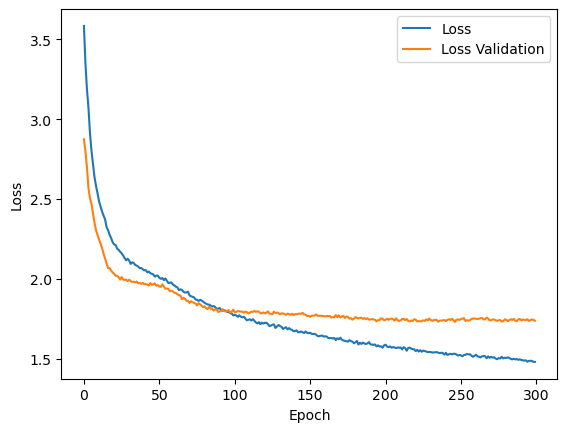

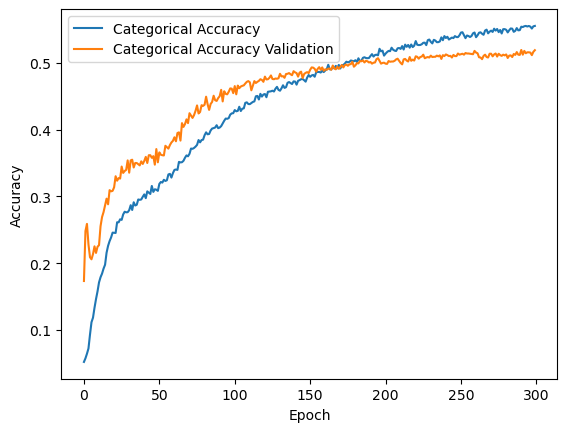

89/89 - 0s - loss: 1.7379 - categorical_accuracy: 0.5193 - 129ms/epoch - 1ms/step
Categorical accuracy para las predicciones en el conjunto de prueba: 0.5193


In [36]:
plot_history(model2_history)

loss, cat_accr = model2.evaluate(X_test, y_test, verbose=2)
print(f"Categorical accuracy para las predicciones en el conjunto de prueba: {np.round(cat_accr,4)}")

89/89 [==============================] - 0s 1ms/step
Resultados de desempeño:
Accuracy: 0.519
Recall: 0.519
Precision: 0.509
F1: 0.51
ROC-AUC: 0.8773753943486374


/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


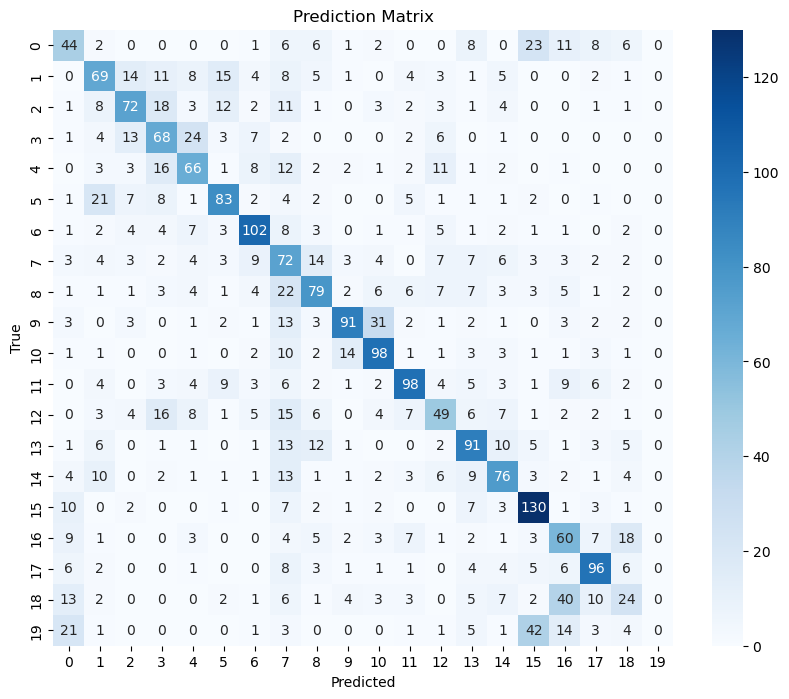

In [37]:
import seaborn as sns

clf = model2
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict(X_test)#[:, 1]

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pmAccuracy=round(accuracy_score(y_test_labels,y_pred_labels),3)
pmRecall=round(recall_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmPrecision=round(precision_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmF1=round(f1_score(y_test_labels, y_pred_labels, average='weighted'),3)

pmRocAuc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Resultados de desempeño:")

#print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

# Create the prediction matrix
prediction_matrix = np.zeros((20, 20), dtype=int)

for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    prediction_matrix[true_label, pred_label] += 1

class_labels = range(20) 
    
# Plot the prediction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(prediction_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction Matrix')
plt.show()

# GridSearch

In [38]:
# Preparamos gridsearch

from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=2)

model = KerasClassifier(
    build_model_for_gridsearch,
    X=X_train,
    y=y_train,
    n_neurons=50,
    activations='sigmoid',
    epochs=300,
    verbose=1,
    callbacks=[es],
    validation_split=0.15,
    #scoring='accuracy'
)

In [39]:
from sklearn.model_selection import GridSearchCV

# ----- Definimos los parámetros de la busqueda -----
neurons = [10,100,200]
activations = ['relu','sigmoid','tanh']
param_grid = {'n_neurons':neurons,
              'activations':activations}

# ----- Definimos y realizamos el gridsearch
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = gs.fit(X_train, y_train)

print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

2023-06-26 02:49:57.291642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:49:57.416536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:49:57.450028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/300
Epoch 1/300
Epoch 1/300


2023-06-26 02:50:00.214921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:50:00.331211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 02:50:00.415198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/300
Epoch 1/300
Epoch 1/300
Epoch 1/300
Epoch 1/300
284/284 [==============================] - 4s 8ms/step - loss: 3.1284 - categorical_accuracy: 0.0485 - val_loss: 2.9953 - val_categorical_accuracy: 0.0512
Epoch 2/300
284/284 [==============================] - 4s 11ms/step - loss: 3.5640 - categorical_accuracy: 0.0481 - val_loss: 3.0073 - val_categorical_accuracy: 0.0556
Epoch 2/300
284/284 [==============================] - 4s 10ms/step - loss: 3.3958 - categorical_accuracy: 0.0506 - val_loss: 2.9920 - val_categorical_accuracy: 0.0512
Epoch 2/300
284/284 [==============================] - 4s 11ms/step - loss: 3.3476 - categorical_accuracy: 0.0523 - val_loss: 2.9941 - val_categorical_accuracy: 0.0568
Epoch 2/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0286 - categorical_accuracy: 0.0514 - val_loss: 2.9939 - val_categorical_accuracy: 0.0499
Epoch 3/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0098 - categorical_accuracy: 0.0532 -

284/284 [==============================] - 4s 13ms/step - loss: 3.1072 - categorical_accuracy: 0.0557 - val_loss: 2.9897 - val_categorical_accuracy: 0.0543
Epoch 5/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9934 - categorical_accuracy: 0.0546 - val_loss: 2.9908 - val_categorical_accuracy: 0.0506
Epoch 9/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9923 - categorical_accuracy: 0.0520 - val_loss: 2.9907 - val_categorical_accuracy: 0.0512
Epoch 9/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9940 - categorical_accuracy: 0.0525 - val_loss: 2.9936 - val_categorical_accuracy: 0.0443
Epoch 9/300
284/284 [==============================] - 5s 14ms/step - loss: 3.3781 - categorical_accuracy: 0.0478 - val_loss: 2.9949 - val_categorical_accuracy: 0.0468
Epoch 2/300
284/284 [==============================] - 2s 9ms/step - loss: 3.0217 - categorical_accuracy: 0.0567 - val_loss: 2.9904 - val_categorical_accuracy: 0.0518
Epoch 8/

284/284 [==============================] - 2s 6ms/step - loss: 2.9906 - categorical_accuracy: 0.0550 - val_loss: 2.9899 - val_categorical_accuracy: 0.0506
Epoch 16/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0746 - categorical_accuracy: 0.0524 - val_loss: 2.9917 - val_categorical_accuracy: 0.0556
Epoch 4/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9919 - categorical_accuracy: 0.0555 - val_loss: 2.9901 - val_categorical_accuracy: 0.0512
Epoch 16/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9914 - categorical_accuracy: 0.0553 - val_loss: 2.9899 - val_categorical_accuracy: 0.0506
Epoch 17/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0482 - categorical_accuracy: 0.0490 - val_loss: 2.9913 - val_categorical_accuracy: 0.0518
Epoch 7/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0008 - categorical_accuracy: 0.0523 - val_loss: 2.9899 - val_categorical_accuracy: 0.0506
Epoch 1

284/284 [==============================] - 2s 7ms/step - loss: 3.0319 - categorical_accuracy: 0.0524 - val_loss: 2.9944 - val_categorical_accuracy: 0.0443
Epoch 8/300
284/284 [==============================] - 2s 7ms/step - loss: 2.9923 - categorical_accuracy: 0.0530 - val_loss: 2.9899 - val_categorical_accuracy: 0.0512
Epoch 24/300
284/284 [==============================] - 2s 8ms/step - loss: 3.0151 - categorical_accuracy: 0.0512 - val_loss: 2.9900 - val_categorical_accuracy: 0.0518
Epoch 14/300
284/284 [==============================] - 2s 6ms/step - loss: 3.0236 - categorical_accuracy: 0.0501 - val_loss: 2.9942 - val_categorical_accuracy: 0.0443
Epoch 9/300
284/284 [==============================] - 4s 10ms/step - loss: 3.3810 - categorical_accuracy: 0.0474 - val_loss: 2.9914 - val_categorical_accuracy: 0.0512
Epoch 2/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9910 - categorical_accuracy: 0.0556 - val_loss: 2.9899 - val_categorical_accuracy: 0.0512
Epoch 2

284/284 [==============================] - 4s 8ms/step - loss: 3.3455 - categorical_accuracy: 0.0525 - val_loss: 2.9958 - val_categorical_accuracy: 0.0443
Epoch 2/300
284/284 [==============================] - 1s 5ms/step - loss: 2.9929 - categorical_accuracy: 0.0549 - val_loss: 2.9895 - val_categorical_accuracy: 0.0506
Epoch 33/300
284/284 [==============================] - 2s 6ms/step - loss: 3.2492 - categorical_accuracy: 0.0477 - val_loss: 2.9965 - val_categorical_accuracy: 0.0443
Epoch 3/300
284/284 [==============================] - 1s 4ms/step - loss: 2.9908 - categorical_accuracy: 0.0551 - val_loss: 2.9895 - val_categorical_accuracy: 0.0506
Epoch 34/300
284/284 [==============================] - 4s 10ms/step - loss: 3.4340 - categorical_accuracy: 0.0556 - val_loss: 2.9910 - val_categorical_accuracy: 0.0531
Epoch 2/300
284/284 [==============================] - 4s 9ms/step - loss: 3.4451 - categorical_accuracy: 0.0513 - val_loss: 2.9933 - val_categorical_accuracy: 0.0506
Epoch 2

284/284 [==============================] - 2s 5ms/step - loss: 3.3881 - categorical_accuracy: 0.0500 - val_loss: 2.9578 - val_categorical_accuracy: 0.0899
Epoch 4/300
284/284 [==============================] - 1s 4ms/step - loss: 3.0715 - categorical_accuracy: 0.0528 - val_loss: 2.9891 - val_categorical_accuracy: 0.0556
Epoch 5/300
284/284 [==============================] - 1s 4ms/step - loss: 3.0504 - categorical_accuracy: 0.0511 - val_loss: 2.9865 - val_categorical_accuracy: 0.0587
Epoch 7/300
284/284 [==============================] - 1s 4ms/step - loss: 3.0509 - categorical_accuracy: 0.0510 - val_loss: 2.9869 - val_categorical_accuracy: 0.0605
Epoch 6/300
284/284 [==============================] - 1s 4ms/step - loss: 3.0515 - categorical_accuracy: 0.0514 - val_loss: 2.9893 - val_categorical_accuracy: 0.0630
Epoch 6/300
284/284 [==============================] - 1s 5ms/step - loss: 3.0312 - categorical_accuracy: 0.0502 - val_loss: 2.9864 - val_categorical_accuracy: 0.0612
Epoch 8/30

284/284 [==============================] - 2s 7ms/step - loss: 3.0241 - categorical_accuracy: 0.0527 - val_loss: 2.9372 - val_categorical_accuracy: 0.1348
Epoch 14/300
284/284 [==============================] - 2s 7ms/step - loss: 3.1585 - categorical_accuracy: 0.0521 - val_loss: 2.9441 - val_categorical_accuracy: 0.1436
Epoch 7/300
284/284 [==============================] - 3s 11ms/step - loss: 3.3118 - categorical_accuracy: 0.0506 - val_loss: 2.9082 - val_categorical_accuracy: 0.1785
Epoch 5/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0406 - categorical_accuracy: 0.0610 - val_loss: 2.8341 - val_categorical_accuracy: 0.1461
Epoch 11/300
284/284 [==============================] - 3s 10ms/step - loss: 3.4174 - categorical_accuracy: 0.0483 - val_loss: 2.9056 - val_categorical_accuracy: 0.1598
Epoch 4/300
284/284 [==============================] - 2s 7ms/step - loss: 3.0123 - categorical_accuracy: 0.0559 - val_loss: 2.9327 - val_categorical_accuracy: 0.1498
Epoch 

284/284 [==============================] - 2s 6ms/step - loss: 2.9585 - categorical_accuracy: 0.0681 - val_loss: 2.7652 - val_categorical_accuracy: 0.1286
Epoch 23/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9946 - categorical_accuracy: 0.0594 - val_loss: 2.8327 - val_categorical_accuracy: 0.1174
Epoch 16/300
284/284 [==============================] - 2s 8ms/step - loss: 3.0670 - categorical_accuracy: 0.0621 - val_loss: 2.8024 - val_categorical_accuracy: 0.2110
Epoch 10/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9356 - categorical_accuracy: 0.0757 - val_loss: 2.7191 - val_categorical_accuracy: 0.1336
Epoch 24/300
284/284 [==============================] - 2s 6ms/step - loss: 2.9761 - categorical_accuracy: 0.0688 - val_loss: 2.7889 - val_categorical_accuracy: 0.1055
Epoch 17/300
284/284 [==============================] - 2s 8ms/step - loss: 2.9953 - categorical_accuracy: 0.0664 - val_loss: 2.6961 - val_categorical_accuracy: 0.1429
Epoch

Best Accuracy: 0.11573742224728922 using parameters {'activations': 'tanh', 'n_neurons': 200}
89/89 [==============================] - 0s 1ms/step
Resultados de desempeño:
Accuracy: 0.108
Recall: 0.108
Precision: 0.053
F1: 0.046
ROC-AUC: 0.5299671206958453


/mnt/run/anaconda3/envs/training9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


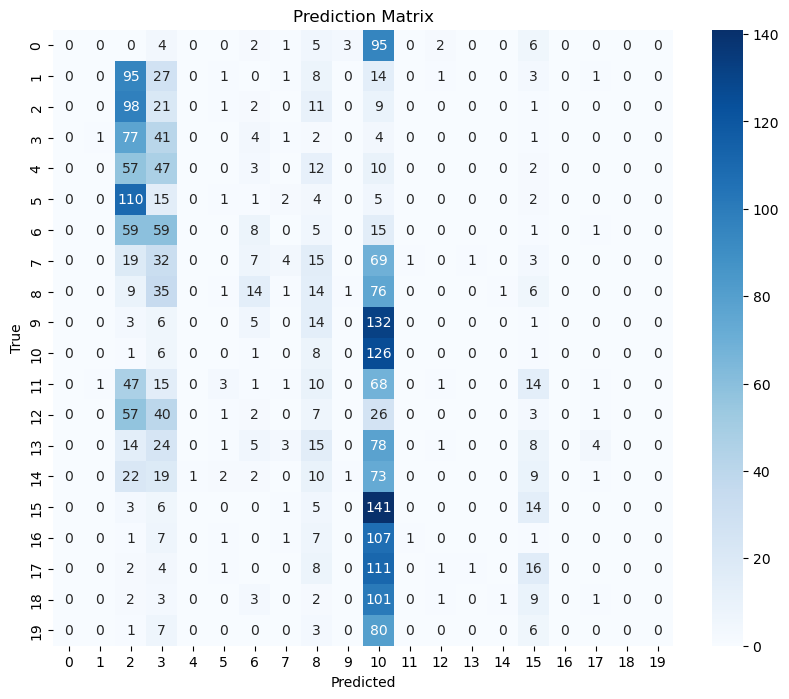

In [41]:
import seaborn as sns
print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

clf = grid_result.best_estimator_

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict(X_test)#[:, 1]

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pmAccuracy=round(accuracy_score(y_test_labels,y_pred_labels),3)
pmRecall=round(recall_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmPrecision=round(precision_score(y_test_labels,y_pred_labels, average='weighted'),3)
pmF1=round(f1_score(y_test_labels, y_pred_labels, average='weighted'),3)

pmRocAuc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Resultados de desempeño:")

#print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")
print(f"F1: {pmF1}")
print(f"ROC-AUC: {pmRocAuc}")

# Create the prediction matrix
prediction_matrix = np.zeros((20, 20), dtype=int)

for true_label, pred_label in zip(y_test_labels, y_pred_labels):
    prediction_matrix[true_label, pred_label] += 1

class_labels = range(20) 
    
# Plot the prediction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(prediction_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Prediction Matrix')
plt.show()